In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", None)

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
print(df_train.shape)
print(df_test.shape)
df_train.head()

(221, 37)
(95, 35)


,event_id,num_perimeters_0_5h,dt_first_last_0_5h,low_temporal_resolution_0_5h,area_first_ha,area_growth_abs_0_5h,area_growth_rel_0_5h,area_growth_rate_ha_per_h,log1p_area_first,log1p_growth,log_area_ratio_0_5h,relative_growth_0_5h,radial_growth_m,radial_growth_rate_m_per_h,centroid_displacement_m,centroid_speed_m_per_h,spread_bearing_deg,spread_bearing_sin,spread_bearing_cos,dist_min_ci_0_5h,dist_std_ci_0_5h,dist_change_ci_0_5h,dist_slope_ci_0_5h,closing_speed_m_per_h,closing_speed_abs_m_per_h,projected_advance_m,dist_accel_m_per_h2,dist_fit_r2_0_5h,alignment_cos,alignment_abs,cross_track_component,along_track_speed,event_start_hour,event_start_dayofweek,event_start_month,time_to_hit_hours,event
0,10892457,3,4.265188,0,79.696304,2.875935,0.036086,0.674281,4.390693,1.354787,0.03545,0.036086,9.007182,2.11179,8.274971,1.940119,70.130507,0.940469,0.339879,6166.121596,0.205085,0.435052,1.090997e-01,-0.102001,0.102001,-0.435052,7.275611e-02,0.886373,-0.054649,0.054649,-1.937219,-0.106026,19,4,5,18.892512,0
1,11757157,2,1.169918,0,8.946749,0.000000,0.000000,0.000000,2.297246,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,2930.925956,0.000000,0.000000,-3.887003e-13,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.568898,0.568898,-0.000000,-0.000000,4,4,6,22.048108,1
2,11945086,4,4.777526,0,106.482638,0.000000,0.000000,0.000000,4.677329,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,3272.375090,0.000000,0.000000,-1.390327e-13,0.000000,0.000000,0.000000,7.965118e-14,0.000000,0.882385,0.882385,0.000000,0.000000,22,4,8,0.888895,1
3,12044083,1,0.000000,1,67.631125,0.000000,0.000000,0.000000,4.228746,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,64119.871377,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20,5,8,60.953021,0
4,12052347,2,4.975273,0,35.632874,0.000000,0.000000,0.000000,3.600946,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,18005.432261,0.000000,0.000000,3.656059e-13,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.934634,0.934634,-0.000000,0.000000,21,5,7,44.990274,0


In [3]:
print(df_train.columns)

Index(['event_id', 'num_perimeters_0_5h', 'dt_first_last_0_5h',
       'low_temporal_resolution_0_5h', 'area_first_ha', 'area_growth_abs_0_5h',
       'area_growth_rel_0_5h', 'area_growth_rate_ha_per_h', 'log1p_area_first',
       'log1p_growth', 'log_area_ratio_0_5h', 'relative_growth_0_5h',
       'radial_growth_m', 'radial_growth_rate_m_per_h',
       'centroid_displacement_m', 'centroid_speed_m_per_h',
       'spread_bearing_deg', 'spread_bearing_sin', 'spread_bearing_cos',
       'dist_min_ci_0_5h', 'dist_std_ci_0_5h', 'dist_change_ci_0_5h',
       'dist_slope_ci_0_5h', 'closing_speed_m_per_h',
       'closing_speed_abs_m_per_h', 'projected_advance_m',
       'dist_accel_m_per_h2', 'dist_fit_r2_0_5h', 'alignment_cos',
       'alignment_abs', 'cross_track_component', 'along_track_speed',
       'event_start_hour', 'event_start_dayofweek', 'event_start_month',
       'time_to_hit_hours', 'event'],
      dtype='str')


## EDA

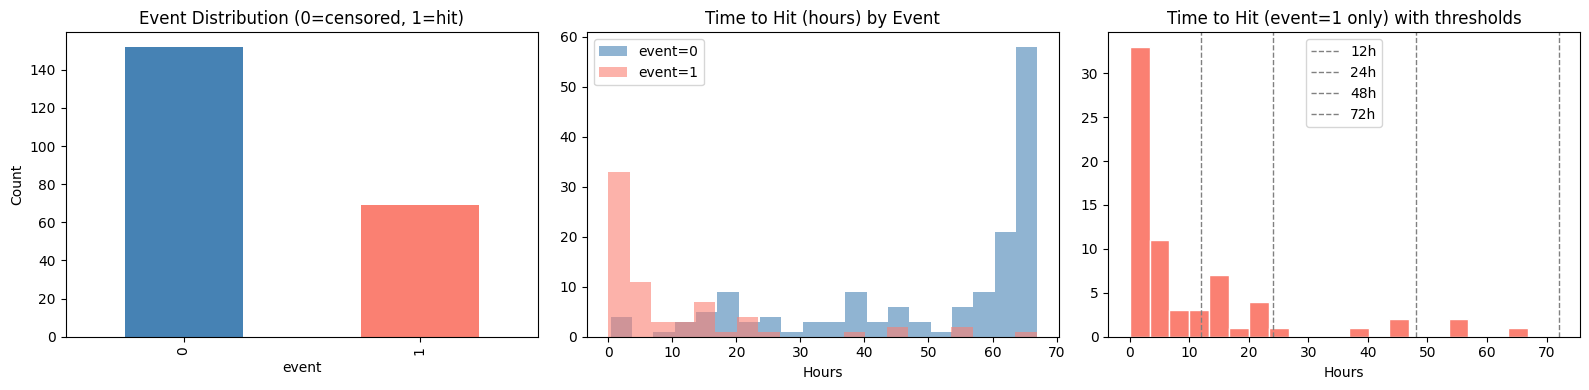

In [5]:
# Target distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Event class balance
df_train["event"].value_counts().plot.bar(ax=axes[0], color=["steelblue", "salmon"])
axes[0].set_title("Event Distribution (0=censored, 1=hit)")
axes[0].set_ylabel("Count")

# Time to hit distribution by event
for label, color in [(0, "steelblue"), (1, "salmon")]:
    subset = df_train[df_train["event"] == label]["time_to_hit_hours"]
    axes[1].hist(subset, bins=20, alpha=0.6, label=f"event={label}", color=color)
axes[1].set_title("Time to Hit (hours) by Event")
axes[1].set_xlabel("Hours")
axes[1].legend()

# Time to hit for event=1 only (zoomed)
hit = df_train[df_train["event"] == 1]["time_to_hit_hours"]
axes[2].hist(hit, bins=20, color="salmon", edgecolor="white")
for t in [12, 24, 48, 72]:
    axes[2].axvline(t, color="gray", ls="--", lw=1, label=f"{t}h")
axes[2].set_title("Time to Hit (event=1 only) with thresholds")
axes[2].set_xlabel("Hours")
axes[2].legend()
plt.tight_layout()
plt.show()

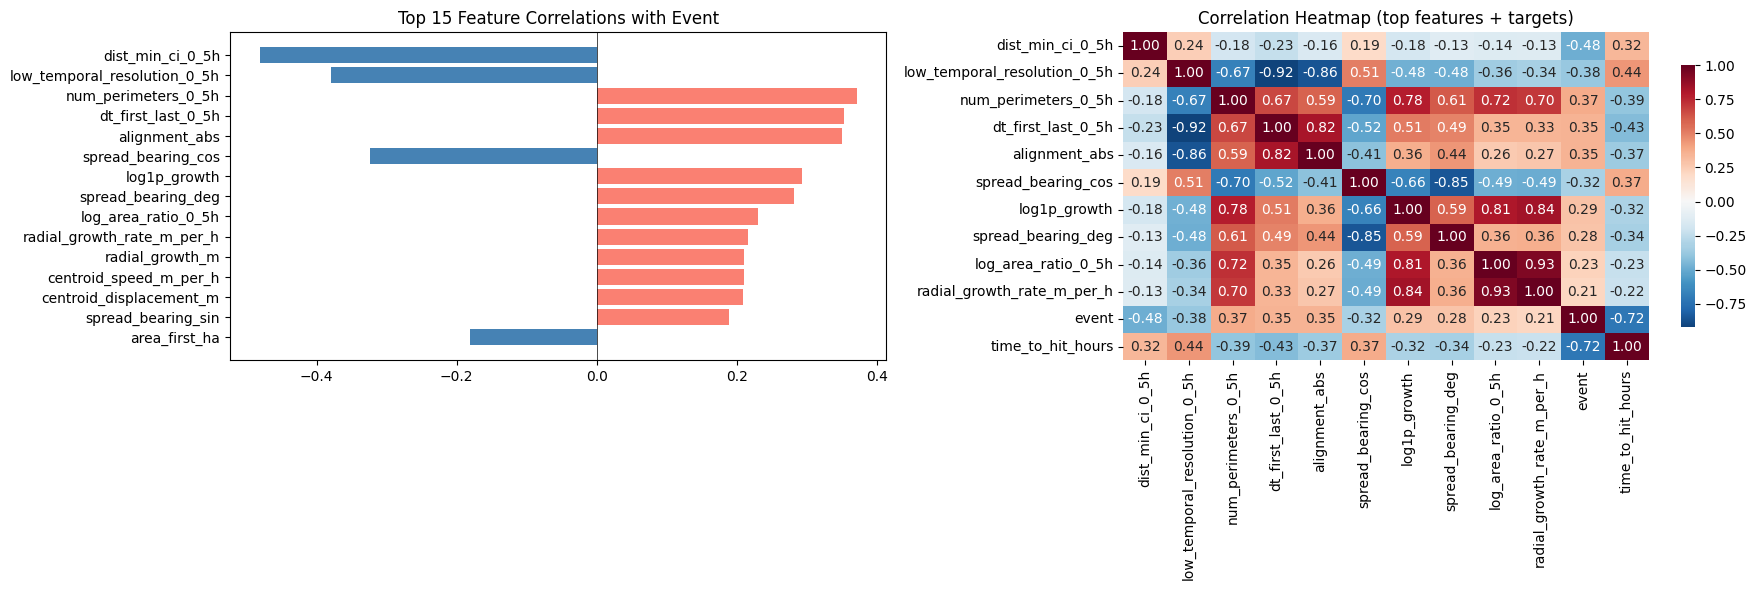

In [ ]:
# Correlation heatmap - top features correlated with event
feature_cols_eda = [c for c in df_train.columns if c not in ["event_id"]]
corr_matrix = df_train[feature_cols_eda].corr()

# Top correlated features with 'event'
top_corr = corr_matrix["event"].drop(["event", "time_to_hit_hours"]).abs().sort_values(ascending=False).head(15)
top_features = top_corr.index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart of correlations
colors = ["salmon" if corr_matrix["event"][f] > 0 else "steelblue" for f in top_features]
axes[0].barh(top_features[::-1], corr_matrix["event"][top_features[::-1]], color=colors[::-1])
axes[0].set_title("Top 15 Feature Correlations with Event")
axes[0].axvline(0, color="black", lw=0.5)

# Correlation heatmap of top features + targets
heatmap_cols = top_features[:10] + ["event", "time_to_hit_hours"]
sns.heatmap(df_train[heatmap_cols].corr(), annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title("Correlation Heatmap (top features + targets)")
plt.tight_layout()
plt.show()

## Preprocessing & Feature Engineering

In [9]:
def engineer_features(df):
    out = df.copy()
    
    # log transform skewed features
    skewed_cols = [
        "area_first_ha", "area_growth_abs_0_5h", "area_growth_rel_0_5h",
        "radial_growth_m", "radial_growth_rate_m_per_h",
        "centroid_displacement_m", "centroid_speed_m_per_h",
        "dist_min_ci_0_5h", "dist_std_ci_0_5h",
        "closing_speed_abs_m_per_h",
    ]
    for col in skewed_cols:
        out[f"log1p_{col}"] = np.log1p(out[col].clip(lower=0))
    
    # interaction features
    out["closing_ratio"] = out["closing_speed_abs_m_per_h"] / (out["dist_min_ci_0_5h"] + 1)
    out["growth_x_alignment"] = out["log1p_growth"] * out["alignment_abs"]
    out["radial_x_alignment"] = out["radial_growth_m"] * out["alignment_abs"]
    out["speed_x_alignment"] = out["centroid_speed_m_per_h"] * out["alignment_abs"]
    
    # distance features
    safe_speed = out["closing_speed_abs_m_per_h"].replace(0, np.nan)
    out["est_time_to_ci"] = (out["dist_min_ci_0_5h"] / safe_speed).clip(upper=500).fillna(500)
    out["close_5km"] = (out["dist_min_ci_0_5h"] < 5000).astype(int)
    out["close_10km"] = (out["dist_min_ci_0_5h"] < 10000).astype(int)
    out["close_20km"] = (out["dist_min_ci_0_5h"] < 20000).astype(int)
    
    # growth rate features
    out["is_growing"] = (out["area_growth_abs_0_5h"] > 0).astype(int)
    out["is_moving"] = (out["centroid_displacement_m"] > 0).astype(int)
    out["growth_per_perimeter"] = out["area_growth_abs_0_5h"] / (out["num_perimeters_0_5h"].clip(lower=1))
    
    # temporal features
    out["hour_sin"] = np.sin(2 * np.pi * out["event_start_hour"] / 24)
    out["hour_cos"] = np.cos(2 * np.pi * out["event_start_hour"] / 24)
    out["month_sin"] = np.sin(2 * np.pi * out["event_start_month"] / 12)
    out["month_cos"] = np.cos(2 * np.pi * out["event_start_month"] / 12)
    out["is_fire_season"] = out["event_start_month"].isin([6, 7, 8, 9]).astype(int)
    out["is_weekend"] = out["event_start_dayofweek"].isin([5, 6]).astype(int)
    
    # danger score
    out["danger_score"] = (
        out["closing_ratio"] * 10
        + out["alignment_abs"] * 5
        + out["is_growing"] * 3
        + (1 - out["low_temporal_resolution_0_5h"]) * 2  # better data = possibly more active fire
    )
    
    return out


# Apply to both train and test
df_train_eng = engineer_features(df_train)
df_test_eng = engineer_features(df_test)

# Define final feature columns
feature_cols_all = [c for c in df_train.columns if c not in ["event_id", "time_to_hit_hours", "event"]]
exclude_cols = {"event_id", "time_to_hit_hours", "event"}
final_feature_cols = [c for c in df_train_eng.columns if c not in exclude_cols]

print(f"Original features: {len(feature_cols_all)}")
print(f"Engineered features: {len(final_feature_cols)}")

Original features: 34
Engineered features: 62


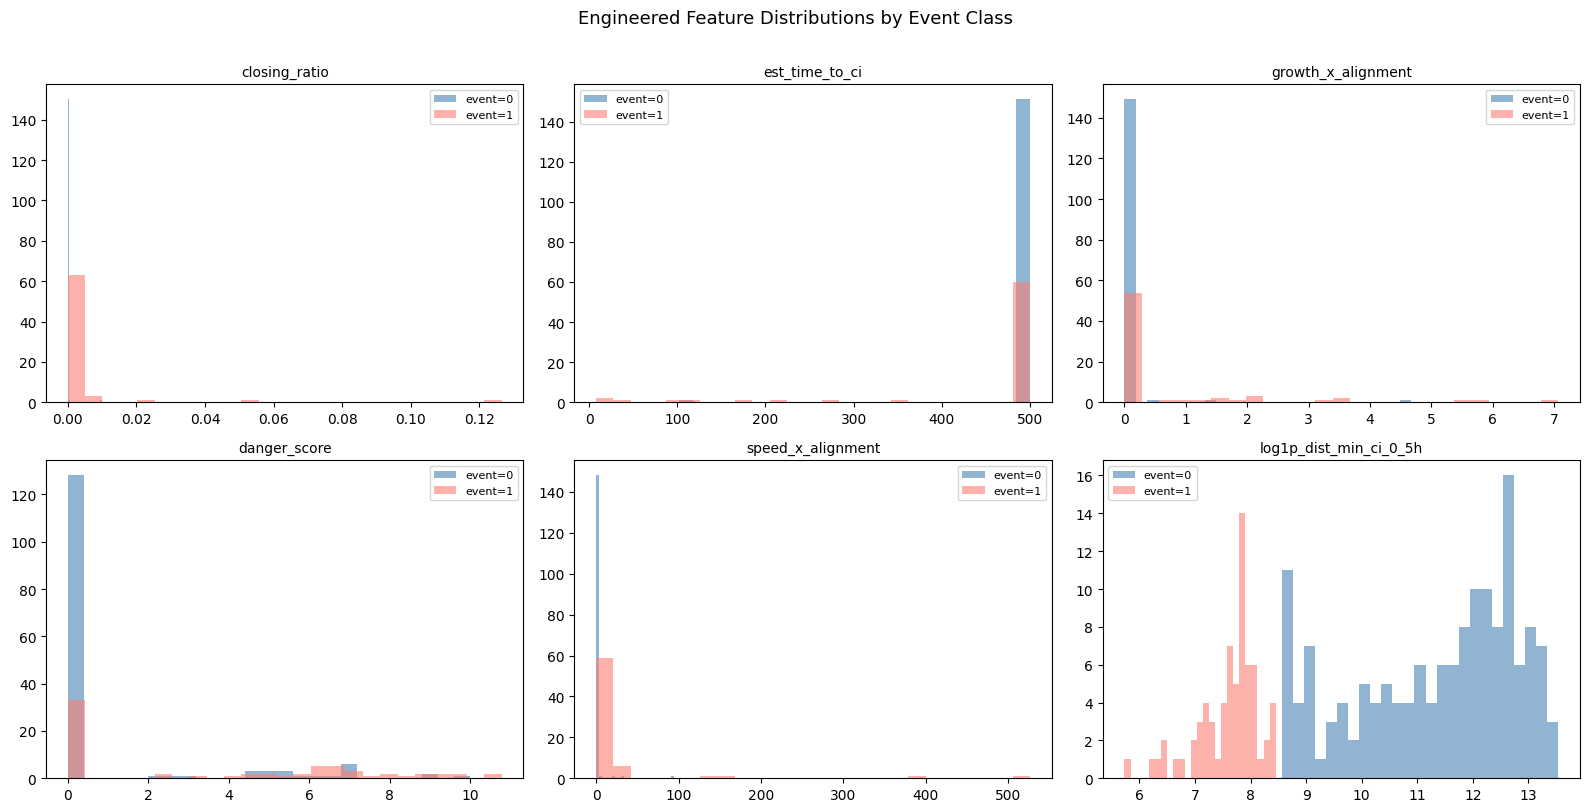

In [10]:
# Visualize new engineered features by event class
eng_feats_to_plot = ["closing_ratio", "est_time_to_ci", "growth_x_alignment",
                     "danger_score", "speed_x_alignment", "log1p_dist_min_ci_0_5h"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for ax, feat in zip(axes.ravel(), eng_feats_to_plot):
    for label, color in [(0, "steelblue"), (1, "salmon")]:
        vals = df_train_eng[df_train_eng["event"] == label][feat]
        ax.hist(vals, bins=25, alpha=0.6, label=f"event={label}", color=color)
    ax.set_title(feat, fontsize=10)
    ax.legend(fontsize=8)
plt.suptitle("Engineered Feature Distributions by Event Class", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## Gradient Boosting per threshold

Threshold 12h — CV ROC-AUC Mean: 0.966
Threshold 24h — CV ROC-AUC Mean: 0.993
Threshold 48h — CV ROC-AUC Mean: 0.999
Threshold 72h — CV ROC-AUC Mean: 1.000


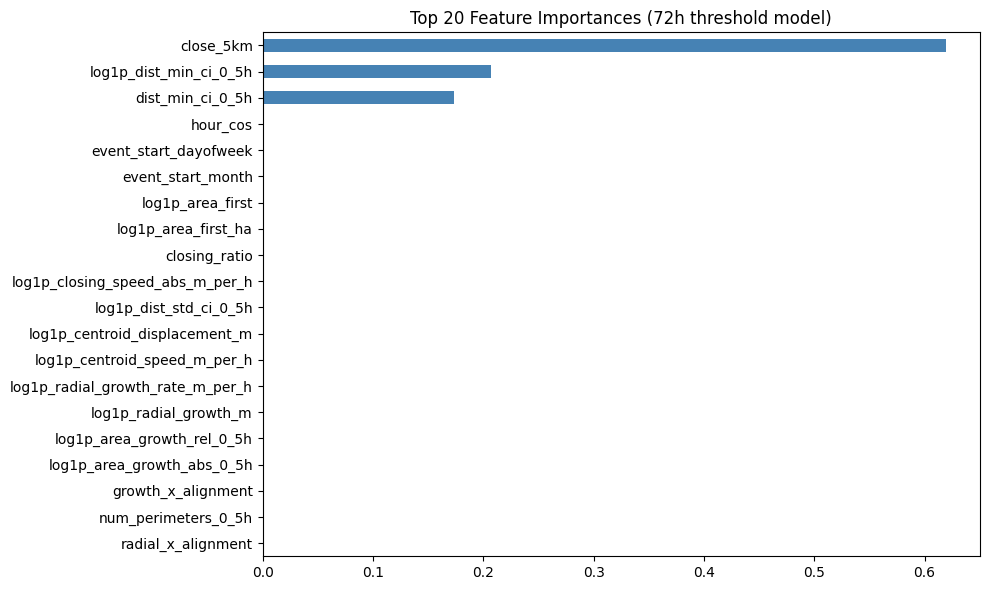

,event_id,prob_12h,prob_24h,prob_48h,prob_72h
0,10662602,0.000292,0.000333,0.000091,0.000014
1,13353600,0.482539,0.999335,0.999911,0.999970
2,13942327,0.000254,0.000572,0.000288,0.000014
3,16112781,0.936815,0.998578,0.999895,0.999970
4,17132808,0.000513,0.000305,0.000036,0.000014
5,17445696,0.000474,0.000398,0.000037,0.000014
6,17599982,0.000260,0.000589,0.000081,0.000014
7,18750374,0.075883,0.830769,0.998825,0.999970
8,21365245,0.000590,0.000517,0.000037,0.000014
9,23634840,0.773676,0.998654,0.999884,0.999970


In [12]:
# Use engineered features
X_train = df_train_eng[final_feature_cols]
X_test = df_test_eng[final_feature_cols]

# Standardize features (helps with regularization, not strictly needed for tree models but good practice)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=final_feature_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=final_feature_cols)

thresholds = [12, 24, 48, 72]
submission = df_test[["event_id"]].copy()

for t in thresholds:
    # binary target: fire reached CI within t hours
    y = ((df_train["event"] == 1) & (df_train["time_to_hit_hours"] <= t)).astype(int)
    
    model = GradientBoostingClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        min_samples_leaf=5,
        random_state=42,
    )
    
    # cross-val score
    cv_scores = cross_val_score(model, X_train_scaled, y, cv=5, scoring="roc_auc")
    print(f"Threshold {t}h — CV ROC-AUC Mean: {cv_scores.mean():.3f}")
    
    model.fit(X_train_scaled, y)
    submission[f"prob_{t}h"] = model.predict_proba(X_test_scaled)[:, 1]

# Show feature importances for last model (72h)
importances = pd.Series(model.feature_importances_, index=final_feature_cols).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))
importances.head(20).plot.barh(ax=ax, color="steelblue")
ax.invert_yaxis()
ax.set_title("Top 20 Feature Importances (72h threshold model)")
plt.tight_layout()
plt.show()

submission.head(10)

In [13]:
# Save submission
submission.to_csv("submission_2.csv", index=False)
print("Saved submission")
print(submission.shape)

Saved submission
(95, 5)
